In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [1]:
import torch, sys, os, random, json
sys.path.append("../scripts/diffuser/")
from dataset import dataset
from torch.utils.data import DataLoader
from accelerate import Accelerator
from tqdm.auto import tqdm
from dataclasses import dataclass
from diffusers import UNet2DConditionModel
from transformers import T5Tokenizer, T5EncoderModel, T5Config
from PIL import Image
from pprint import pprint
from diffusers import DDPMScheduler
import torch.nn.functional as F
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers.utils.torch_utils import randn_tensor


In [15]:
from diffusers import DiffusionPipeline
repo_id = "CompVis/stable-diffusion-v1-4"
pipe = DiffusionPipeline.from_pretrained(repo_id, torch_dtype=torch.float16, revision="fp16")


vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/home/yingshan/clevr_control/venv/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [16]:
pipe.unet.config

FrozenDict([('sample_size', 64),
            ('in_channels', 4),
            ('out_channels', 4),
            ('center_input_sample', False),
            ('flip_sin_to_cos', True),
            ('freq_shift', 0),
            ('down_block_types',
             ['CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'DownBlock2D']),
            ('mid_block_type', 'UNetMidBlock2DCrossAttn'),
            ('up_block_types',
             ['UpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D']),
            ('only_cross_attention', False),
            ('block_out_channels', [320, 640, 1280, 1280]),
            ('layers_per_block', 2),
            ('downsample_padding', 1),
            ('mid_block_scale_factor', 1),
            ('dropout', 0.0),
            ('act_fn', 'silu'),
            ('norm_num_groups', 32),
            ('norm_eps', 1e-05),
            ('cross_attenti

In [2]:
@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 4
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 5
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 5
    save_image_epochs = 1
    save_model_epochs = 5
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "../scripts/diffuser/output"  
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

In [6]:
"load" in dir(config)

False

In [3]:
data = dataset(
    metadata_dir="../data/matplotlib/colored_sq/split1/", 
    image_dir = "../data/matplotlib/colored_sq/images/", 
    split = "train"
)
train_dataloader = DataLoader(data, batch_size=config.train_batch_size, shuffle=True)

In [13]:

model = UNet2DConditionModel(
    sample_size=128,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 256, 1024),  # the number of output channels for each UNet block
    down_block_types=(
        "CrossAttnDownBlock2D",  # a regular ResNet downsampling block
        "CrossAttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "CrossAttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "CrossAttnUpBlock2D",
    ),
    encoder_hid_dim=None,
    encoder_hid_dim_type=None,
    transformer_layers_per_block=1,
    cross_attention_dim=512,
)

In [14]:
model.cuda()

UNet2DConditionModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 64, eps=1e-06, affine=True)
          (proj_in): LoRACompatibleConv(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): LoRACompatibleLinear(in_features=64, out_features=64, bias=False)
                (to_k): LoRACompatibleLinear(in_features=64, out_features=64, bias=False)
                (to_v): LoR

In [6]:
tokenizer = T5Tokenizer.from_pretrained("t5-small", torch_dtype=torch.float16)
text_encoder = T5EncoderModel.from_pretrained("t5-small", torch_dtype=torch.float16)
text_encoder.cuda()
text_encoder.eval()
device = "cuda:0"

batch = next(iter(train_dataloader))

text_inputs = tokenizer.batch_encode_plus(
        batch['sentence'],
        return_tensors = "pt",
        padding = 'longest',
        max_length = 64,
        truncation = True
    )
with torch.no_grad():
    prompt_embeds = text_encoder(
            text_inputs.input_ids.to(device),
            text_inputs.attention_mask.to(device)
        )
    prompt_embeds = prompt_embeds.last_hidden_state.detach().to(dtype=torch.float32)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [7]:
sample_image = batch['image'].to(device)
print("Input shape:", sample_image.shape)

print("Output shape:", model(sample_image, encoder_hidden_states=prompt_embeds, timestep=0).sample.shape)

Input shape: torch.Size([4, 3, 128, 128])
Output shape: torch.Size([4, 3, 128, 128])


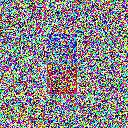

In [8]:
# forward pass: add noise
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape).to(device)
timesteps = torch.LongTensor([50]).to(device)
noisy_image = noise_scheduler.add_noise(sample_image[0], noise, timesteps)

Image.fromarray(((noisy_image.detach().cpu().permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])


In [9]:

noise_pred = model(sample_image, encoder_hidden_states=prompt_embeds, timestep=timesteps).sample
# objective: MSE
loss = F.mse_loss(noise_pred, noise)

In [10]:
# create optimizer, lr_scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [33]:

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    #evaluate(config, accelerator.unwrap_model(model), 0)
    
    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            if step % 60 == 0: evaluate(config, accelerator.unwrap_model(model), f"{epoch}_{step}")
            text_inputs = tokenizer.batch_encode_plus(
                    batch['sentence'],
                    return_tensors = "pt",
                    padding = 'longest',
                    max_length = 64,
                    truncation = True
                )
            with torch.no_grad():
                prompt_embeds = text_encoder(
                        text_inputs.input_ids.to(device),
                        text_inputs.attention_mask.to(device)
                    )
                prompt_embeds = prompt_embeds.last_hidden_state.detach()

            clean_images = batch["image"]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, encoder_hidden_states=prompt_embeds, timestep=timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, accelerator.unwrap_model(model), epoch)

            #if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                #pipeline.save_pretrained(config.output_dir)

In [34]:
# launch accelerate inside notebook
from accelerate import notebook_launcher

print(f"total epochs: {config.num_epochs}")
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

total epochs: 5
Launching training on one GPU.


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
batch = next(iter(train_dataloader))
text_inputs = tokenizer.batch_encode_plus(
    batch['sentence'][:1],
    return_tensors = "pt",
    padding = 'longest',
    max_length = 64,
    truncation = True
)
with torch.no_grad():
    prompt_embeds = text_encoder(
    text_inputs.input_ids.to(device),
    text_inputs.attention_mask.to(device)
)
prompt_embeds = prompt_embeds.last_hidden_state.detach()
image_shape = (1, model.config.in_channels, model.config.sample_size, model.config.sample_size)
image = randn_tensor(image_shape, device=device)

for t in tqdm(noise_scheduler.timesteps):
    model_output = model(image, encoder_hidden_states=prompt_embeds, timestep=t).sample
    image = noise_scheduler.step(model_output, t, image).prev_sample
image = (image / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()

In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])